table of contents
1. 準備
2. データのインポート
3. シュートポイントの可視化

# 準備

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

# データのインポート

In [3]:
base_dir = os.path.join('..','..')
data_dir = os.path.join(base_dir, 'data', 'raw')

def read_dfs():
    players_df = pd.read_json(os.path.join(data_dir, 'players.json'))
    teams_df = pd.read_json(os.path.join(data_dir, 'teams.json'))

    # encode, decode
    players_df['shortName'] = players_df.shortName.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    teams_df['name'] = teams_df.name.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    return players_df, teams_df

players_df, teams_df = read_dfs()

competition_list = [infile.replace('matches_','').replace('.json','') for infile in os.listdir(os.path.join(data_dir, 'matches')) if infile.endswith('.json')]

print(competition_list)

['World_Cup', 'Italy', 'Germany', 'England', 'France', 'Spain', 'European_Championship']


In [4]:
selected_competition = 'European_Championship'

def read_events_df(selected_competition):
    events_df = pd.read_json(os.path.join(data_dir, 'events', f'events_{selected_competition}.json'))
    return events_df

def read_matches_df(selected_competition):
    matches_df = pd.read_json(os.path.join(data_dir, 'matches', f'matches_{selected_competition}.json'))
    matches_df['date_time'] = pd.to_datetime(matches_df.dateutc)

    # encode, decode
    matches_df['label'] = matches_df.label.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    matches_df['venue'] = matches_df.venue.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    # concate label, venue, date_time
    matches_df['name'] = matches_df[['label', 'venue', 'date_time']].apply(lambda xs: f'{xs[0]} @{xs[1]}, {xs[2].date()}', axis=1)

    return matches_df.sort_values('date_time')

matches_df = read_matches_df(selected_competition)

name_list = matches_df.name.tolist()
print(name_list)

['France - Romania, 2 - 1 @Stade de France, 2016-06-10', 'Albania - Switzerland, 0 - 1 @Stade Bollaert-Delelis, 2016-06-11', 'Wales - Slovakia, 2 - 1 @Stade Matmut-Atlantique, 2016-06-11', 'England - Russia, 1 - 1 @Stade Vélodrome, 2016-06-11', 'Turkey - Croatia, 0 - 1 @Parc des Princes, 2016-06-12', 'Poland - Northern Ireland, 1 - 0 @Allianz Riviera, 2016-06-12', 'Germany - Ukraine, 2 - 0 @Stade Pierre-Mauroy, 2016-06-12', 'Spain - Czech Republic, 1 - 0 @Stadium Municipal, 2016-06-13', 'Republic of Ireland - Sweden, 1 - 1 @Stade de France, 2016-06-13', 'Belgium - Italy, 0 - 2 @Groupama Stadium, 2016-06-13', 'Austria - Hungary, 0 - 2 @Stade Matmut-Atlantique, 2016-06-14', 'Portugal - Iceland, 1 - 1 @Stade Geoffroy-Guichard, 2016-06-14', 'Russia - Slovakia, 1 - 2 @Stade Pierre-Mauroy, 2016-06-15', 'Romania - Switzerland, 1 - 1 @Parc des Princes, 2016-06-15', 'France - Albania, 2 - 0 @Stade Vélodrome, 2016-06-15', 'England - Wales, 2 - 1 @Stade Bollaert-Delelis, 2016-06-16', 'Ukraine - N

In [7]:
selected_match = 'Germany - France, 0 - 2 @Stade Vélodrome, 2016-07-07'
selected_wyId = matches_df[matches_df.name == selected_match].wyId.values[0]

events_df = read_events_df(selected_competition)

matchPeriod_list = ['1H', '2H']

df_tmp = events_df[(events_df.matchId == selected_wyId)&(events_df.eventName=='Shot')&(events_df.matchPeriod.isin(matchPeriod_list))]

# シュートポイントの可視化

## 関数の定義

In [8]:
from plotly.subplots import make_subplots

def draw_pitches(nrows, ncols, title_list=[], colorbar=False):

    COLOR = 'white'
    twitter_color = 'rgb(20,29,38)'

    # Create traces
    fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=title_list, horizontal_spacing=0.05, vertical_spacing=0.05)
    for i in range(1,nrows+1):
        for j in range(1,ncols+1):
            
            line_list = [[[0,120], [0,0]], [[120,120], [0,80]], [[120,0], [80,80]], [[0,0], [80,0]], [[60,60], [0,80]]]
            line_list += [[[0,18], [18,18]], [[18,18], [18,62]], [[18,0], [62,62]], [[0,6], [30,30]], [[6,6], [30,50]], [[6,0], [50,50]]]
            line_list += [[[120, 102], [18,18]], [[102,102], [18,62]], [[102,120], [62,62]], [[120,114], [30,30]], [[114,114], [30,50]], [[114,120], [50,50]]]

            for [x, y] in line_list:
                fig.add_trace(go.Scatter(x=x, y=y,
                                    mode='lines',
                                    line=dict(color=COLOR, width=2.5),
                                    showlegend=False,
                                    hoverinfo='none'
                                    )
                             , row=i, col=j)

            line_list = [[[0,0], [36,44]], [[120,120], [36,44]]]
            for [x, y] in line_list:
                fig.add_trace(go.Scatter(x=x, y=y,
                                    mode='lines',
                                    line=dict(color=COLOR, width=12.5),
                                    showlegend=False,
                                    hoverinfo='none'
                                    )
                             , row=i, col=j)

            fig.add_shape(go.layout.Shape(type='circle', x0=60-12, y0=40-12, x1=60+12, y1=40+12, line_color=COLOR, line_width=2.5), row=i, col=j)
            fig.update_xaxes(range=[-1, 120+1], visible=False, row=i, col=j)
            fig.update_yaxes(range=[-1, 80+1], visible=False, row=i, col=j)
    
    fig.update_layout(go.Layout(width=120*10, height=80*10, plot_bgcolor=twitter_color, paper_bgcolor=twitter_color, autosize=True, margin=dict(l=10, r=10, t=20, b=10)))
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=15,color=COLOR)
    
    return fig

## 可視化

In [52]:
title_list = [f'{matchPeriod} {teams_df[teams_df.wyId==teamId].name.values[0]}' for [matchPeriod, teamId] in df_tmp[['matchPeriod', 'teamId']].drop_duplicates().sort_values(by=['teamId', 'matchPeriod']).values.tolist()]
fig = draw_pitches(2, 2, title_list)

In [37]:
XMAX, XMIN = 120, 0
YMAX, YMIN = 80, 0

df_tmp['x'] = None
df_tmp['y'] = None
df_tmp[['x', 'y']] = df_tmp.apply(lambda xs: [XMAX*xs['positions'][0]['x']/100, YMAX*(1-xs['positions'][0]['y']/100)], result_type='expand', axis=1)

/Users/saeru/.pyenv/versions/anaconda3-5.3.0/envs/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/saeru/.pyenv/versions/anaconda3-5.3.0/envs/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
df_tmp['result'] = df_tmp.apply(lambda xs: 'success' if 101 in [tag['id'] for tag in xs['tags']] else 'failure', axis=1)

/Users/saeru/.pyenv/versions/anaconda3-5.3.0/envs/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
df_tmp.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x,y,result
74679,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1202}, {'id'...",3682,"[{'y': 41, 'x': 86}, {'y': 100, 'x': 100}]",1694439,Shot,4418,1H,363.376287,100,90356598,103.2,47.2,failure
74790,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1212}, {'id'...",14732,"[{'y': 65, 'x': 90}, {'y': 0, 'x': 0}]",1694439,Shot,3148,1H,740.879991,100,90356733,108.0,28.0,failure
74810,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1205}, {'id'...",18550,"[{'y': 50, 'x': 85}, {'y': 0, 'x': 0}]",1694439,Shot,3148,1H,812.556361,100,90356762,102.0,40.0,failure
74813,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",3319,"[{'y': 36, 'x': 90}, {'y': 0, 'x': 0}]",1694439,Shot,3148,1H,817.997093,100,90356768,108.0,51.2,failure
74846,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",14732,"[{'y': 29, 'x': 76}, {'y': 0, 'x': 0}]",1694439,Shot,3148,1H,895.109015,100,90356794,91.2,56.8,failure


In [53]:
for i, (matchPeriod, teamId) in enumerate(df_tmp[['matchPeriod', 'teamId']].drop_duplicates().sort_values(by=['teamId', 'matchPeriod']).values.tolist()):
    i, j = int(i/2)+1, i%2+1
    fig.add_trace(
        go.Scatter(
            x=df_tmp[(df_tmp.matchPeriod==matchPeriod)&(df_tmp.teamId==teamId)].x.tolist()
            , y=df_tmp[(df_tmp.matchPeriod==matchPeriod)&(df_tmp.teamId==teamId)].y.tolist()
            , mode='markers'
            , marker=dict(color=['red' if result=='success' else 'blue' for result in df_tmp[(df_tmp.matchPeriod==matchPeriod)&(df_tmp.teamId==teamId)].result.tolist()])
            , hover_data=df_tmp[(df_tmp.matchPeriod==matchPeriod)&(df_tmp.teamId==teamId)].y.tolist()
        )
        , row=i, col=j)

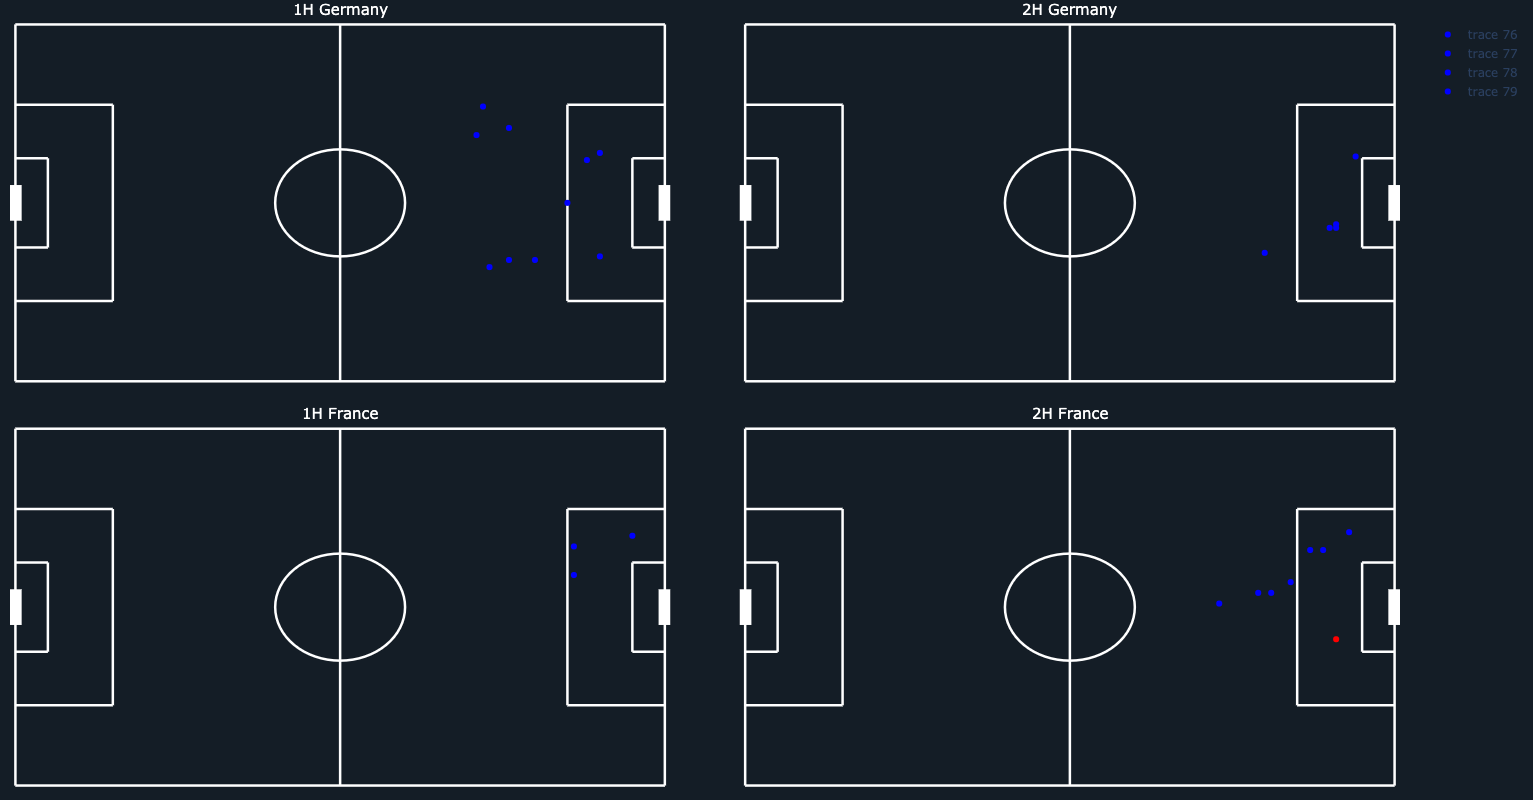

In [54]:
fig.show()